<a href="https://colab.research.google.com/github/Kerriea-star/TensorFlow-Customization/blob/main/Custom_Training_Walkthrough.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This project shows how to train a machine learning model with a custom training loop to categorize penguins by species. In this notebook, you use TensorFlow to accomplish the following:

1.   Import a dataset
2.   Build a simple linear model
3.   Train the model
5.   Evaluate the model
6.   Use the trained model to make predictions



## TensorFlow programming

This tutorial demonstrates the following TensorFlow programming tasks:

*   Importing data with the TensorFlow Datasets API
*   Building models and layers with the Keras API



## Penguin classification problem

Imagine you are an ornithologist seeking an automated way to categorize each penguin you find. Machine learning provides many algorithms to classify penguins statistically. For instance, a sophisticated machine learning program could classify penguins based on photographs. The model you build in this project is a little simpler. It classifies penguins based on their body weight, flipper length, and beaks, specifically the length and width measurements of their culmen.

There are 18 species of penguins, but in this tutorial you will only attempt to classify the following three:

*   Chinstrap penguins
*   Gentoo penguins
*   Adélie penguins


Fortunately, a research team has already created and shared a dataset of 334 penguins with body weight, flipper length, beak measurements, and other data. This dataset is also conveniently available as the penguins TensorFlow Dataset.


### Setup

Install the `tfds-nightly` package for the penguins dataset. `The tfds-nightly` package is the nightly released version of the TensorFlow Datasets (TFDS).

In [1]:
!pip install -q tfds-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 38.6 MB/s eta 0:00:00


Import TensorFlow and the other required Python modules

In [2]:
import os
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

print("TensorFlow version: {}".format(tf.__version__))
print("TensorFlow Datasets version: ", tfds.__version__)

TensorFlow version: 2.13.0
TensorFlow Datasets version:  4.9.3+nightly


#### Import the dataset

The default penguins/processed TensorFlow Dataset is already cleaned, normalized, and ready for building a model. Before you download the processed data, preview a simplified version to get familiar with the original penguin survey data

#### Preview the data

Download the simplified version of the penguins dataset (penguins/simple) using the TensorFlow Datasets tfds.load method. There are 344 data records in this dataset. Extract the first five records into a DataFrame object to inspect a sample of the values in this dataset:

In [3]:
ds_preview, info = tfds.load('penguins/simple', split='train', with_info=True)
df = tfds.as_dataframe(ds_preview.take(5), info)
print(df)
print(info.features)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/344 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/simple/1.0.0.incompleteO4B9UP/penguins-train.tfrecord*...:   0%| …

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/simple/1.0.0. Subsequent calls will reuse this data.
   body_mass_g  culmen_depth_mm  culmen_length_mm  flipper_length_mm  island  \
0       4200.0             13.9         45.500000              210.0       0   
1       4650.0             13.7         40.900002              214.0       0   
2       5300.0             14.2         51.299999              218.0       0   
3       5650.0             15.0         47.799999              215.0       0   
4       5050.0             15.8         46.299999              215.0       0   

   sex  species  
0    0        2  
1    0        2  
2    1        2  
3    1        2  
4    1        2  
FeaturesDict({
    'body_mass_g': float32,
    'culmen_depth_mm': float32,
    'culmen_length_mm': float32,
    'flipper_length_mm': float32,
    'island': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'sex': ClassLabel(shape=(), dtype=int64, num_classes=3),
    'species

The numbered rows are data records, one example per line, where:

*   The first six fields are features: these are the characteristics of an example. Here, the fields hold numbers representing penguin measurements.
*   The last column is the label: this is the value you want to predict. For this dataset, it's an integer value of 0, 1, or 2 that corresponds to a penguin species name.

In the dataset, the label for the penguin species is represented as a number to make it easier to work with in the model you are building. These numbers correspond to the following penguin species:

*   `0`: Adélie penguin
*   `1`: Chinstrap penguin
*   `2`: Gentoo penguin

Create a list containing the penguin species names in this order. You will use this list to interpret the output of the classification model:


In [4]:
class_names = ["Adélie", "Chinstrap", "Gentoo"]

### Download the preprocessed dataset

Now, download the preprocessed penguins dataset (penguins/processed) with the tfds.load method, which returns a list of tf.data.Dataset objects. Note that the penguins/processed dataset doesn't come with its own test set, so use an 80:20 split to slice the full dataset into the training and test sets. You will use the test dataset later to verify your model.

In [5]:
ds_split, info = tfds.load("penguins/processed", split=["train[:20%]", "train[:20%]"], as_supervised=True, with_info=True)

ds_test = ds_split[0]
ds_train = ds_split[1]
assert isinstance(ds_test, tf.data.Dataset)

print(info.features)
df_test = tfds.as_dataframe(ds_test.take(5), info)
print("Test dataset sample: ")
print(df_test)

df_train = tfds.as_dataframe(ds_train.take(5), info)
print("Train dataset sample: ")
print(df_train)

ds_train_batch = ds_train.batch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/334 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/penguins/processed/1.0.0.incompleteKWM7BT/penguins-train.tfrecord*...:   0…

Dataset penguins downloaded and prepared to /root/tensorflow_datasets/penguins/processed/1.0.0. Subsequent calls will reuse this data.
FeaturesDict({
    'features': Tensor(shape=(4,), dtype=float32),
    'species': ClassLabel(shape=(), dtype=int64, num_classes=3),
})
Test dataset sample: 
                                         features  species
0  [0.6545454, 0.22619048, 0.89830506, 0.6388889]        2
1        [0.36, 0.04761905, 0.6440678, 0.4027778]        2
2       [0.68, 0.30952382, 0.91525424, 0.6944444]        2
3   [0.6181818, 0.20238096, 0.8135593, 0.6805556]        2
4  [0.5527273, 0.26190478, 0.84745765, 0.7083333]        2
Train dataset sample: 
                                         features  species
0  [0.6545454, 0.22619048, 0.89830506, 0.6388889]        2
1        [0.36, 0.04761905, 0.6440678, 0.4027778]        2
2       [0.68, 0.30952382, 0.91525424, 0.6944444]        2
3   [0.6181818, 0.20238096, 0.8135593, 0.6805556]        2
4  [0.5527273, 0.26190478, 0.84745765

Notice that this version of the dataset has been processed by reducing the data down to four normalized features and a species label. In this format, the data can be quickly used to train a model without further processing.

In [6]:
features, labels = next(iter(ds_train_batch))

print(features)
print(labels)

tf.Tensor(
[[0.6545454  0.22619048 0.89830506 0.6388889 ]
 [0.36       0.04761905 0.6440678  0.4027778 ]
 [0.68       0.30952382 0.91525424 0.6944444 ]
 [0.6181818  0.20238096 0.8135593  0.6805556 ]
 [0.5527273  0.26190478 0.84745765 0.7083333 ]
 [0.17818181 0.45238096 0.22033899 0.08333334]
 [0.3090909  0.48809522 0.2542373  0.21527778]
 [0.6872727  0.6785714  0.5254237  0.3888889 ]
 [0.33454546 0.95238096 0.3898305  0.4722222 ]
 [0.20727272 0.5952381  0.3559322  0.29166666]
 [0.32       0.6904762  0.20338982 0.33333334]
 [0.7490909  0.79761904 0.42372882 0.2847222 ]
 [0.6909091  0.3809524  0.8135593  0.9166667 ]
 [0.37818182 0.5        0.2542373  0.18055555]
 [0.38545454 0.07142857 0.6101695  0.3472222 ]
 [0.05090909 0.70238096 0.30508474 0.25      ]
 [0.46545455 0.02380952 0.69491524 0.6666667 ]
 [0.5672727  0.22619048 0.7457627  0.5694444 ]
 [0.21818182 0.6547619  0.30508474 0.2777778 ]
 [0.47636363 0.08333334 0.7288136  0.5694444 ]
 [0.17454545 0.6547619  0.2881356  0.22222222]
 [

You can visualize some clusters by plotting a few features from the batch:

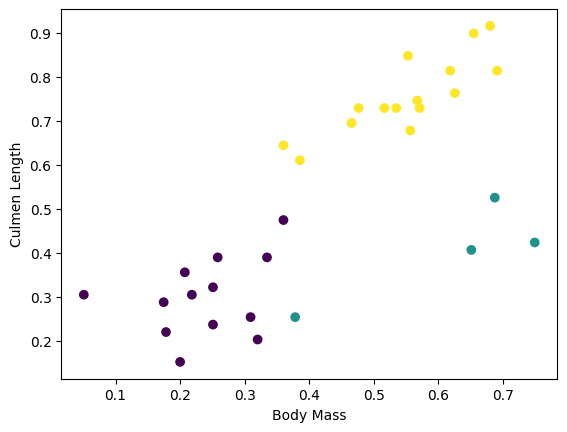

In [7]:
plt.scatter(features[:, 0],
            features[:, 2],
            c=labels,
            cmap='viridis')

plt.xlabel("Body Mass")
plt.ylabel("Culmen Length")
plt.show()

## Build a simple linear model
#### Why model?

A model is a relationship between features and the label. For the penguin classification problem, the model defines the relationship between the body mass, flipper and culmen measurements and the predicted penguin species. Some simple models can be described with a few lines of algebra, but complex machine learning models have a large number of parameters that are difficult to summarize.

Could you determine the relationship between the four features and the penguin species without using machine learning? That is, could you use traditional programming techniques (for example, a lot of conditional statements) to create a model? Perhaps—if you analyzed the dataset long enough to determine the relationships between body mass and culmen measurements to a particular species. And this becomes difficult—maybe impossible—on more complicated datasets. A good machine learning approach determines the model for you. If you feed enough representative examples into the right machine learning model type, the program figures out the relationships for you.

####Select the model

Next you need to select the kind of model to train. There are many types of models and picking a good one takes experience. This tutorial uses a neural network to solve the penguin classification problem. Neural networks can find complex relationships between features and the label. It is a highly-structured graph, organized into one or more hidden layers. Each hidden layer consists of one or more neurons. There are several categories of neural networks and this program uses a dense, or fully-connected neural network: the neurons in one layer receive input connections from every neuron in the previous layer. For example, Figure 2 illustrates a dense neural network consisting of an input layer, two hidden layers, and an output layer:

<table>
  <tr><td>
    <img src="https://www.tensorflow.org/tutorials/customization/images/full_network_penguin.png" alt="A diagram of the network architecture: Inputs, 2 hidden layers, and outputs"
     class="no-filter">
  </td></tr>
  <tr><td align="center">
    <b>Figure 2.</b> A neural network with features, hidden layers, and predictions.<br/>&nbsp;
  </td></tr>
</table>

When you train the model from Figure 2 and feed it an unlabeled example, it yields three predictions: the likelihood that this penguin is the given penguin species. This prediction is called `inference`. For this example, the sum of the output predictions is `1.0`. In Figure 2, this prediction breaks down as: `0.02` for Adelie, `0.95` for Chinstrap, and `0.03` for Gentoo species. This means that the model predicts—with 95% probability—that an unlabeled example penguin is a Chinstrap penguin.

### Create a model using Keras

The TensorFlow `tf.keras` API is the preferred way to create models and layers. This makes it easy to build models and experiment while Keras handles the complexity of connecting everything together.

The `tf.keras.Sequential` model is a linear stack of layers. Its constructor takes a list of layer instances, in this case, two `tf.keras.layers.Dense` layers with 10 nodes each, and an output layer with 3 nodes representing your label predictions. The first layer's `input_shape` parameter corresponds to the number of features from the dataset, and is required:

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation=tf.nn.relu, input_shape=(4,)), # input shape required
    tf.keras.layers.Dense(10, activation=tf.nn.relu),
    tf.keras.layers.Dense(3)
])

The `activation function` determines the output shape of each node in the layer. These non-linearities are important—without them the model would be equivalent to a single layer. There are many `tf.keras.activations`, but `ReLU` is common for hidden layers.

The ideal number of hidden layers and neurons depends on the problem and the dataset. Like many aspects of machine learning, picking the best shape of the neural network requires a mixture of knowledge and experimentation. As a rule of thumb, increasing the number of hidden layers and neurons typically creates a more powerful model, which requires more data to train effectively.

### Use the model

Let's have a quick look at what this model does to a batch of features:

In [9]:
predictions = model(features)
predictions[:5]

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[ 0.20804316, -0.03869784,  0.11017084],
       [ 0.06926437, -0.02367667,  0.02807583],
       [ 0.24453801, -0.04000869,  0.1239005 ],
       [ 0.19485852, -0.03043755,  0.09103815],
       [ 0.20544064, -0.03831139,  0.07291158]], dtype=float32)>

Here, each example returns a logit for each class.

To convert these logits to a probability for each class, use the softmax function:

In [10]:
tf.nn.softmax(predictions[:5])

<tf.Tensor: shape=(5, 3), dtype=float32, numpy=
array([[0.3720089 , 0.29066655, 0.33732453],
       [0.34832337, 0.3174087 , 0.33426788],
       [0.378973  , 0.2851223 , 0.33590472],
       [0.37041605, 0.29569566, 0.3338883 ],
       [0.37600216, 0.2946661 , 0.32933185]], dtype=float32)>

Taking the `tf.math.argmax` across classes gives us the predicted class index. But, the model hasn't been trained yet, so these aren't good predictions:

In [11]:
print("Prediction: {}".format(tf.math.argmax(predictions, axis=1)))
print("    Labels: {}".format(labels))

Prediction: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
    Labels: [2 2 2 2 2 0 0 1 0 0 0 1 2 1 2 0 2 2 0 2 0 2 2 2 0 0 0 0 1 0 2 2]


## Train the model

`Training`is the stage of machine learning when the model is gradually optimized, or the model learns the dataset. The goal is to learn enough about the structure of the training dataset to make predictions about unseen data. If you learn too much about the training dataset, then the predictions only work for the data it has seen and will not be generalizable. This problem is called `overfitting`—it's like memorizing the answers instead of understanding how to solve a problem.

The penguin classification problem is an example of `supervised machine learning`: the model is trained from examples that contain labels. In `unsupervised machine learning`, the examples don't contain labels. Instead, the model typically finds patterns among the features.

### Define the loss and gradients function

Both training and evaluation stages need to calculate the model's `loss`. This measures how off a model's predictions are from the desired label, in other words, how bad the model is performing. You want to minimize, or optimize, this value.

Your model will calculate its loss using the `tf.keras.losses.SparseCategoricalCrossentropy` function which takes the model's class probability predictions and the desired label, and returns the average loss across the examples.

In [12]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

In [13]:
def loss(model, x, y, training):
    # training=training is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    y_ = model(x, training=training)

    return loss_object(y_true=y, y_pred=y_)
l = loss(model, features, labels, training=False)
print("Loss test: {}".format(l))

Loss test: 1.0753962993621826


Use the `tf.GradientTape` context to calculate the gradients used to optimize your model:

In [14]:
def grad(model, inputs, targets):
  with tf.GradientTape() as tape:
    loss_value = loss(model, inputs, targets, training=True)
  return loss_value, tape.gradient(loss_value, model.trainable_variables)

### Create an optimizer
An `optimizer` applies the computed gradients to the model's parameters to minimize the `loss` function. You can think of the loss function as a curved surface (refer to Figure 3) and you want to find its lowest point by walking around. The gradients point in the direction of steepest ascent—so you'll travel the opposite way and move down the hill. By iteratively calculating the loss and gradient for each batch, you'll adjust the model during training. Gradually, the model will find the best combination of weights and bias to minimize the loss. And the lower the loss, the better the model's predictions.

<table>
  <tr><td>
    <img src="https://cs231n.github.io/assets/nn3/opt1.gif" width="70%"
         alt="Optimization algorithms visualized over time in 3D space.">
  </td></tr>
  <tr><td align="center">
    <b>Figure 3.</b> Optimization algorithms visualized over time in 3D space.<br/>(Source: <a href="http://cs231n.github.io/neural-networks-3/">Stanford class CS231n</a>, MIT License, Image credit: <a href="https://twitter.com/alecrad">Alec Radford</a>)
  </td></tr>
</table>

TensorFlow has many optimization algorithms available for training. In this project, we will use the `tf.keras.optimizers.SGD` that implements the `stochastic gradient descent (SGD) algorithm`. The `learning_rate` parameter sets the step size to take for each iteration down the hill. This rate is a `hyperparameter` that you'll commonly adjust to achieve better results.

Instantiate the optimizer with a `learning rate` of `0.01`, a scalar value that is multiplied by the gradient at each iteration of the training:

In [15]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

Then use this object to calculate a single optimization step:

In [16]:
loss_value, grads = grad(model, features, labels)

print("Step: {}, Initial Loss: {}".format(optimizer.iterations.numpy(),
                                          loss_value.numpy()))

optimizer.apply_gradients(zip(grads, model.trainable_variables))

print("Step: {},        Loss: {}".format(optimizer.iterations.numpy(),
                                         loss(model, features, labels, training=True).numpy()))


Step: 0, Initial Loss: 1.0753962993621826
Step: 1,        Loss: 1.0742125511169434


###Training loop

With all the pieces in place, the model is ready for training! A training loop feeds the dataset examples into the model to help it make better predictions. The following code block sets up these training steps:

1.   Iterate each epoch. An epoch is one pass through the dataset.
2.   Within an epoch, iterate over each example in the training Dataset grabbing its features (`x`) and label (`y`).
3.   Using the example's features, make a prediction and compare it with the label. Measure the inaccuracy of the prediction and use that to calculate the model's loss and gradients.
4.   Use an `optimizer` to update the model's parameters.
5.   Keep track of some stats for visualization.
6.   Repeat for each epoch.

The `num_epochs` variable is the number of times to loop over the dataset collection. In the code below, `num_epochs` is set to 201 which means this training loop will run 201 times. Counter-intuitively, training a model longer does not guarantee a better model. `num_epochs` is a `hyperparameter` that you can tune. Choosing the right number usually requires both experience and experimentation



In [17]:
## Note: Rerunning this cell uses the same model parameters

# Keep results for plotting
train_loss_results = []
train_accuracy_results = []

num_epochs = 201

for epoch in range(num_epochs):
  epoch_loss_avg = tf.keras.metrics.Mean()
  epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

  # Training loop - using batches of 32
  for x, y in ds_train_batch:
    # Optimize the model
    loss_value, grads = grad(model, x, y)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Track progress
    epoch_loss_avg.update_state(loss_value) # add current batch loss
    # Compare predicted label to actual label
    # training=True is needed only if there are layers with different
    # behavior during training versus inference (e.g. Dropout).
    epoch_accuracy.update_state(y, model(x, training=True))

  # End epoch
  train_loss_results.append(epoch_loss_avg.result())
  train_accuracy_results.append(epoch_accuracy.result())

  if epoch % 50 == 0:
    print("Epoch {:03d}: Loss: {:.3f}, Accuracy: {:.3%}".format(epoch,
                                                                epoch_loss_avg.result(),
                                                                epoch_accuracy.result()))


Epoch 000: Loss: 1.109, Accuracy: 38.806%
Epoch 050: Loss: 1.064, Accuracy: 40.299%
Epoch 100: Loss: 1.034, Accuracy: 53.731%
Epoch 150: Loss: 0.997, Accuracy: 68.657%
Epoch 200: Loss: 0.946, Accuracy: 79.104%
